In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import xobjects as xo
import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('../PIMMStutorials_CNAOlattice/cnao_lattice_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/429 [00:00<?, ?it/s]

Done loading line from dict.           


### Define reference particle

In [4]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=60e6)

### Match

In [5]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-3, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.666, qy=1.74, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 3.415         
Matching: model call n. 22               
Optimize - end penalty:  3.10671e-06


### Twiss

In [6]:
tw = line.twiss(method='4d')

In [7]:
# Dispersion and beta function at the electrostatic septum
tw["dx", "se_010a_esp"] , tw["betx", "se_010a_esp"]

(np.float64(3.944835268352582), np.float64(16.517485217887586))

### Set realistic septum aperture

In [8]:
x_ap = 0.035
line['septum_aperture'].max_x = x_ap

### Switch to multithreaded context to gain speed

In [9]:
ctx = xo.ContextCpu(omp_num_threads='auto')

### Build a matched beam distribution

In [10]:
# Geometric emittance calculation for normalised_emittance=0.52e-6
em_g = 0.52e-6 / (line.particle_ref._beta0 * line.particle_ref._gamma0)

In [11]:
# Calculate the maximum n for the "grid"
x_ap / np.sqrt(em_g * tw["betx", "se_010a_esp"])

array([7.19821269])

In [12]:
n_max = 8

In [13]:
# Calculate the maximum delta for the "grid"
x_ap / tw["dx", "se_010a_esp"]

np.float64(0.00887236034436908)

In [14]:
delta_max = 1e-2

In [15]:
# Define number of turns and number of particles for the simulation
num_turns = 15000
num_particles = 400

x_distribution = np.linspace(0, n_max, 20)

delta_distribution = np.linspace(0, delta_max, 19) 
r_delta = (5./3 - tw.qx)/np.abs(tw.dqx)
delta_distribution = np.append(delta_distribution, r_delta)
delta_distribution.sort()

# Build Particles
particles = line.build_particles(
    x_norm = np.tile(x_distribution, 20),
    px_norm = np.zeros(num_particles),
    y_norm = np.random.normal(size=num_particles),
    py_norm = np.random.normal(size=num_particles),
    delta = np.repeat(delta_distribution, 20),
    zeta= np.zeros(num_particles),
    method='4d',
    nemitt_x=0.52e-6, nemitt_y=1e-8
)

p0 = particles.copy()
nc = tw.get_normalized_coordinates(p0)

0.00022220096052455248


Text(0, 0.5, 'normalised pzeta (delta)')

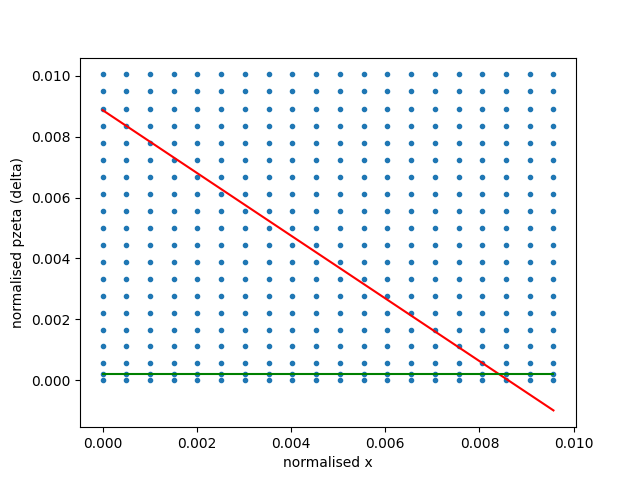

In [16]:
# Draw the diagonal line (aperture cut)
AP_cut=(x_ap-x_distribution*np.sqrt(em_g*tw["betx", "se_010a_esp"]))/tw["dx", "se_010a_esp"]

# Draw the horizontal resonance line
R_cut=(5./3 - tw.qx)/np.abs(tw.dqx)
print(R_cut)

# Plot the "grid"
plt.figure()
plt.plot(nc.x_norm, nc.pzeta_norm, '.')
plt.plot(x_distribution*np.sqrt(em_g),AP_cut,"r-")
plt.plot(x_distribution*np.sqrt(em_g), R_cut * np.ones(len(x_distribution)), "g-")
plt.xlabel("normalised x")
plt.ylabel("normalised pzeta (delta)")

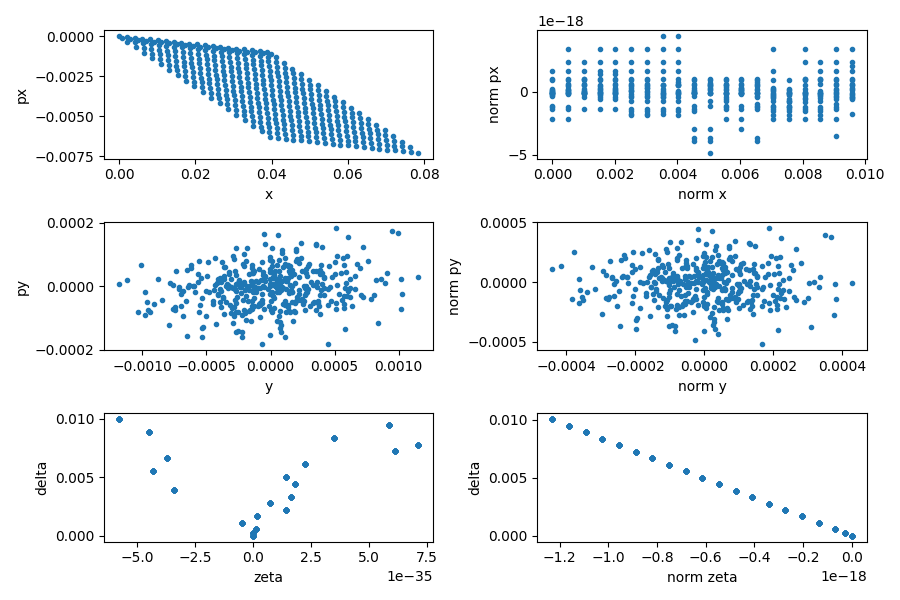

In [17]:
# Plot transverse and longitudinal phase spaces 
# (both physical and normalised)
plt.figure(figsize=(9,6))
a1 = plt.subplot(3, 2, 1)
a1 = plt.plot(p0.x, p0.px, ".")
plt.xlabel('x')
plt.ylabel('px')

a2 = plt.subplot(3, 2, 2)
a2 = plt.plot(nc.x_norm, nc.px_norm, ".")
plt.xlabel('norm x')
plt.ylabel('norm px')

a3 = plt.subplot(3, 2, 3)
a3 = plt.plot(p0.y, p0.py, ".")
plt.xlabel('y')
plt.ylabel('py')

a4 = plt.subplot(3, 2, 4)
a4 = plt.plot(nc.y_norm, nc.py_norm, ".")
plt.xlabel('norm y')
plt.ylabel('norm py')

a5 = plt.subplot(3, 2, 5)
a5 = plt.plot(p0.zeta, p0.delta, ".")
plt.xlabel('zeta')
plt.ylabel('delta')

a6 = plt.subplot(3, 2, 6)
a6 = plt.plot(nc.zeta_norm, nc.pzeta_norm, ".")
plt.xlabel('norm zeta')
plt.ylabel('delta')

plt.tight_layout()

### Define time-dependent bevior of extraction sextupole

In [18]:
line.functions['fun_xsext'] = xt.FunctionPieceWiseLinear(
    x=[0, 5000*tw.T_rev0, 8000*tw.T_rev0],   # <-- selection based on the number of turns
    y=[0, 0, 1.]
)

line.vars['sr'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])

### Define quantities to be logged during tracking

In [19]:
# User-defined quantity to be logged (functions executed at every turn, output is automatically logged).
def measure_intensity(line, particles):
    mask_alive = particles.state > 0
    intensity = np.sum(particles.weight[mask_alive])
    return intensity

# Enable time-dependent vars update for tracking
line.enable_time_dependent_vars = True

### Define a function for calculating the statistical RMS emittance of the beam

In [20]:
def statistical_rms_emittance(line, particles):
    rms_em = np.sqrt(np.average(particles.x**2)*np.average(particles.px**2)-np.average(particles.x*particles.px)**2)
    return rms_em

### Introduce RF Cavity

In [21]:
# Calculate the revolotion frequency
f_rev = 1 / tw.T_rev0
# Create RF_Cavity element
rf_cavity = xt.Cavity(voltage=1e3, frequency=f_rev)

In [22]:
line.discard_tracker()
# Remove the rf cavity element from CNAO lattice (considered a drift) 
# and place the custom rf cavity (thin element) in the center of the original one.
line.remove('s8_020a_cav')
line.insert('rf_cavity', rf_cavity, at=49.2291)

line.build_tracker(_context=ctx)

Slicing line:   0%|          | 0/429 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [23]:
# Calculate the maximum momentum acceptance for a stable bucket
delta_acceptance = np.sqrt(2*line["rf_cavity"].voltage/(np.pi*np.abs(tw.slip_factor)*line.particle_ref.p0c.item()*tw.beta0))
print(delta_acceptance)

0.0029560120471913394


In [24]:
# Reset simulation time
line.vars['t_turn_s'] = 0

### Log excitation parameters

In [25]:
# User-defined functions to be logged
log = xt.Log('t_turn_s', 'sr',
             intensity=measure_intensity, 
             rms_emittance=statistical_rms_emittance)       

### Track!

In [26]:
line.track(p0, num_turns=num_turns, with_progress=True, turn_by_turn_monitor=True,
           log=log)

Tracking:   0%|          | 0/15000 [00:00<?, ?it/s]

In [27]:
# Record particle coordinates turn by turn
rec = line.record_last_track

### Plot logged quantities

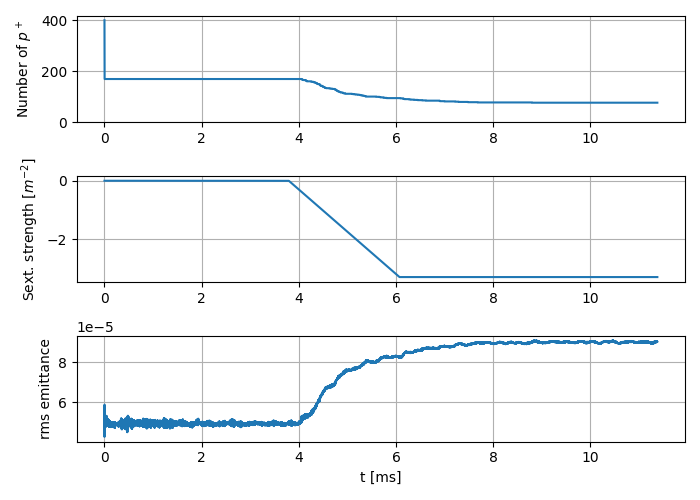

In [31]:
plt.figure(figsize=(7, 5))

t_ms = np.array(line.log_last_track['t_turn_s']) * 1e3

ax1 = plt.subplot(3,1,1)
plt.plot(t_ms, line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Number of $p^+$')
plt.grid()

# Checking if the resonance sextupole off
ax2 = plt.subplot(3,1,2)
plt.plot(t_ms, line.log_last_track['sr'])
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.grid()

# Plot the emittance of the beam with respect to time
ax3 = plt.subplot(3,1,3, sharex=ax1)
plt.plot(t_ms, line.log_last_track['rms_emittance'])
plt.xlabel('t [ms]')
plt.ylabel('rms emittance')
plt.grid()

plt.tight_layout()

### Plot particles after tracking

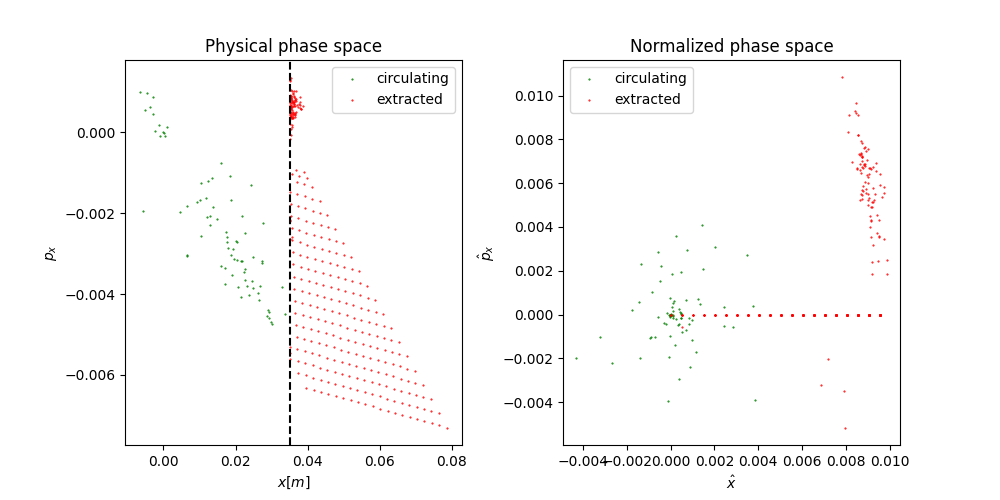

In [32]:
mask_alive = p0.state>0
mask_lost = ~mask_alive

# Get particles normalized coordinates
p_nc = tw.get_normalized_coordinates(p0)

plt.figure(figsize=(10, 5))
ax_g = plt.subplot(1, 2, 1, title='Physical phase space')
ax_n = plt.subplot(1, 2, 2, title='Normalized phase space')

ax_g.plot(p0.x[mask_alive], p0.px[mask_alive],
         '.', markersize=1, color='green', label='circulating')
ax_g.plot(p0.x[mask_lost], p0.px[mask_lost],
         '.', markersize=1, color='red', label='extracted')
ax_g.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
ax_g.set_xlabel(r'${x} [m]$')
ax_g.set_ylabel(r'${p}_x$')
ax_g.legend()

ax_n.plot(p_nc.x_norm[mask_alive], p_nc.px_norm[mask_alive],
         '.', markersize=1, color='green', label='circulating')
ax_n.plot(p_nc.x_norm[mask_lost], p_nc.px_norm[mask_lost],
         '.', markersize=1, color='red', label='extracted')
ax_n.set_aspect('equal', adjustable='datalim')
ax_n.set_xlabel(r'$\hat{x}$')
ax_n.set_ylabel(r'$\hat{p}_x$')
ax_n.legend()

plt.subplots_adjust(wspace=0.3)

plt.show()

## Longitudinal phase space

In [33]:
# Indices of the particles with zero n
np.where(np.tile(x_distribution, 20)==0)[0]

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360, 380])

Text(0, 0.5, '$\\delta$')

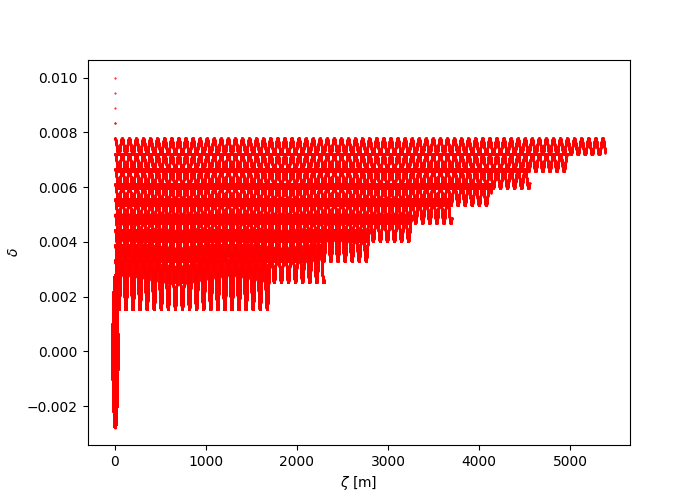

In [34]:
# Plot longitudinal phase space for the previously selected particles and for every turn
plt.figure(figsize=(7,5))
plt.plot(rec.zeta[np.where(np.tile(x_distribution, 20)==0)[0],:], 
         rec.delta[np.where(np.tile(x_distribution, 20)==0)[0], :], '.', markersize=1, color="red")
plt.xlabel(r'$\zeta$ [m]')
plt.ylabel(r'$\delta$')

Text(0, 0.5, 'delta')

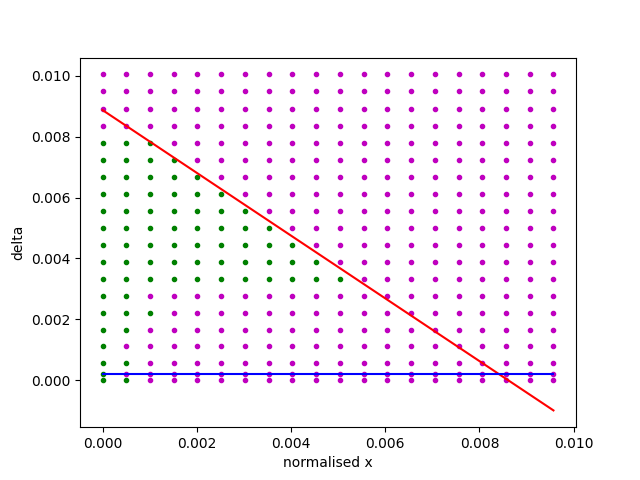

In [35]:
# Plot the grid after tracking (purple dots are the lost particles and green are the alive)
plt.figure()
plt.plot(nc.x_norm[p0.particle_id[mask_alive]], nc.pzeta_norm[p0.particle_id[mask_alive]], "g.")
plt.plot(nc.x_norm[p0.particle_id[mask_lost]], nc.pzeta_norm[p0.particle_id[mask_lost]], "m.")
plt.plot(x_distribution*np.sqrt(em_g),AP_cut,"r-")
plt.plot(x_distribution*np.sqrt(em_g), R_cut * np.ones(len(x_distribution)), "b-")
plt.xlabel('normalised x')
plt.ylabel('delta')